In [1]:
USE_CUDA = False
VERBOSE = False

In [101]:
if USE_CUDA:
    import cudf

    %load_ext cudf.pandas
import pandas as pd
import importlib
import workbench.src.data_loader as data_loader
import workbench.src.graph as graph
import workbench.src.data_process as data_process
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import src.feature_select as feature_select
from IPython.core.display import Markdown
from workbench.utils import utils
import numpy as np
import matplotlib.colors as mcolors

In [3]:
pd.set_option("max_colwidth", 8000)
pd.options.display.max_rows = 1000
pd.set_option("display.width", 500)
pd.set_option("display.max_colwidth", 5000)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_columns", 200)

/tmp/ipykernel_17118/1998127023.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [102]:
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

base_cmap = sns.color_palette("crest", as_cmap=True)

colors = base_cmap(np.arange(base_cmap.N))
colors[0, :] = [0, 0, 0, 0]
custom_cmap = mcolors.ListedColormap(colors)

In [5]:
importlib.reload(data_loader)
data = data_loader.load_data(inc_players=True)

In [6]:
importlib.reload(data_process)
rolling_stats: data_process.RollingMatchTeamStats = (
    data_process.append_rolling_match_team_stats(data)
)
dual_df = rolling_stats.dual_df
importlib.reload(data_process)
full_df = data_process.add_team_strategies(
    source_df=dual_df, team_attrs_df=data.team_attrs_df
)

In [7]:
if VERBOSE:
    data.matches_df

# EDA

The goal of this is to provide a general overview of the dataset and to select the features that can be used in our model.

We'll focus on:
- Analyzing the differences between national leagues:
- Goal scoring data based on teams and players
- The "closeness" in performance between teams by league (basically whether some leagues are dominated by a small number of teams or whether all team are similarly strong)

### Football Leagues

In [8]:
data.matches_df["total_goals"] = (
        data.matches_df["home_team_goal"] + data.matches_df["away_team_goal"]
)
league_matches_by_year = (
    data.matches_df.groupby(["league_name", "season_start_year"])
    .size()
    .unstack(fill_value=0)
)
median_goals_per_league = (
    data.matches_df.groupby(["league_name", "season_start_year"])["total_goals"]
    .mean()
    .reset_index()
)
median_goals_all_leagues = (
    data.matches_df.groupby("season_start_year")["total_goals"].mean().reset_index()
)

In [9]:
if VERBOSE:
    league_matches_by_year.dtypes

/tmp/ipykernel_17118/4035172131.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/tmp/ipykernel_17118/4035172131.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


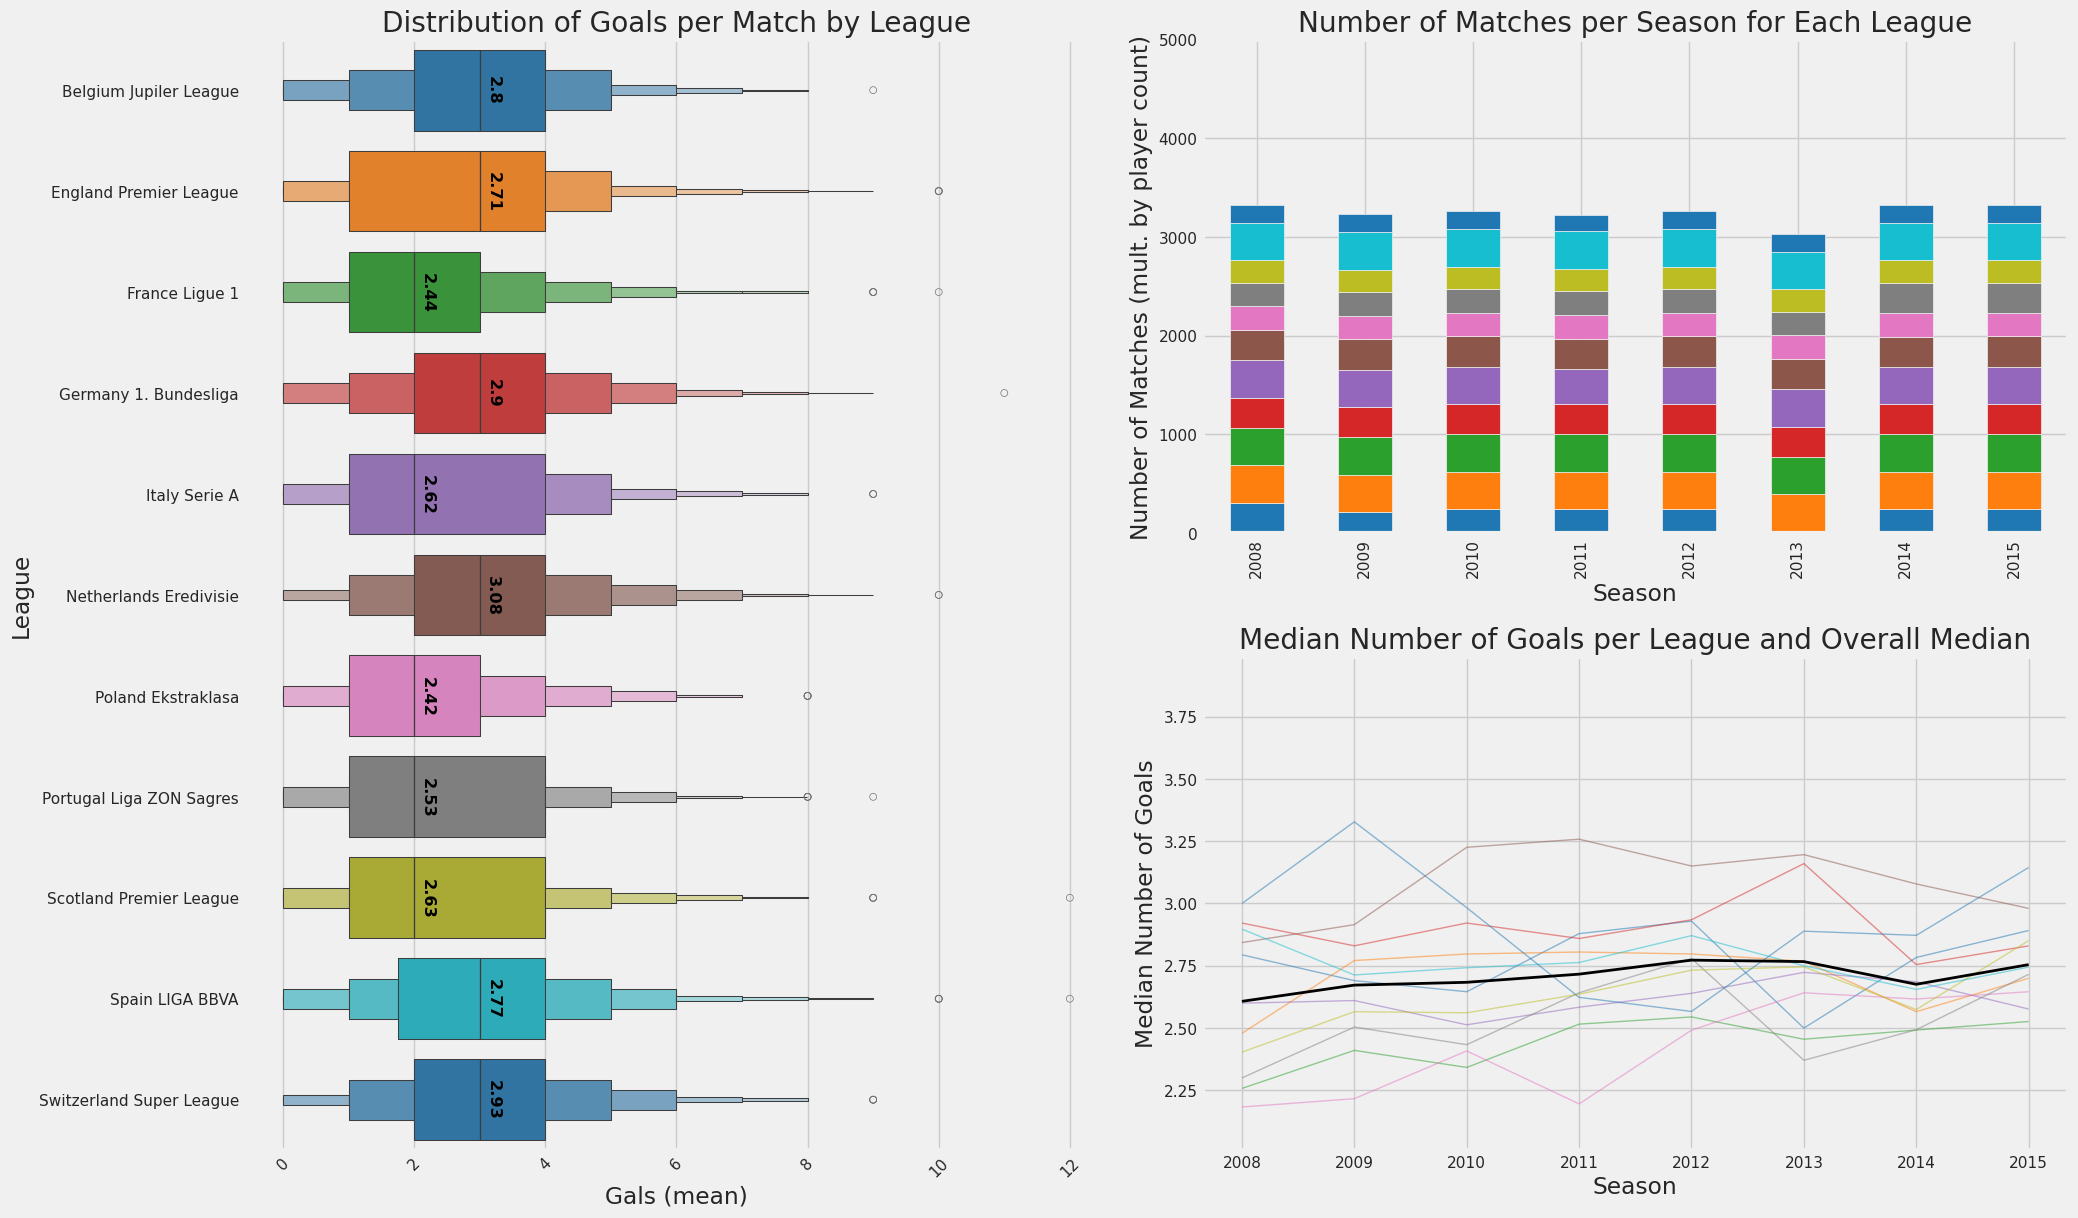

In [10]:
fig = plt.figure(figsize=(21, 18))
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2, fig=fig)
ax2 = plt.subplot2grid((3, 2), (0, 1), fig=fig)
ax3 = plt.subplot2grid((3, 2), (1, 1), fig=fig)
palette = plt.cm.tab10.colors
unique_leagues = data.matches_df["league_name"].unique()
league_color_mapping = {
    league: palette[i % len(palette)] for i, league in enumerate(unique_leagues)
}

sns.boxenplot(
    ax=ax1,
    data=data.matches_df,
    y="league_name",
    x="total_goals",
    color="b",
    linewidth=0.75,
    palette=league_color_mapping
    # order=clarity_ranking,
    # width_method="linear",
)

ax1.set_title("Distribution of Goals per Match by League")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Annotate each mean line with rounded mean goals value
medians = data.matches_df.groupby("league_name")["total_goals"].median()
means = data.matches_df.groupby("league_name")["total_goals"].mean()
for i, league in enumerate(medians.index):
    mean_value = round(means[league], 2)
    ax1.text(
        medians[league] + 0.2,
        i,
        f"{mean_value}",
        horizontalalignment="center",
        verticalalignment="center",
        size="small",
        color="black",
        weight="semibold",
        rotation=270,
    )

# league_matches_by_year.T.plot(kind="bar", stacked=True, ax=ax2, legend=False)
league_matches_by_year.T.plot(
    kind="bar",
    stacked=True,
    ax=ax2,
    legend=False,
    color=[league_color_mapping[league] for league in league_matches_by_year.index],
)

ax2.set_title("Number of Matches per Season for Each League")
ax2.set_ylabel("Number of Matches (mult. by player count)")
ax2.set_ylim([0, 5000])

sns.lineplot(
    ax=ax3,
    data=median_goals_per_league,
    x="season_start_year",
    y="total_goals",
    hue="league_name",
    palette=league_color_mapping,
    legend=False,
    alpha=0.5,
    linewidth=1,
)
sns.lineplot(
    ax=ax3,
    data=median_goals_all_leagues,
    x="season_start_year",
    y="total_goals",
    color="black",
    linewidth=2,
)
ax1.set_ylabel("League")
ax1.set_xlabel("Gals (mean)")

ax2.set_xlabel("Season")

ax3.set_ylabel("Median Number of Goals")
ax3.set_xlabel("Season")
ax3.set_title("Median Number of Goals per League and Overall Median")
ax3.set_ylim([2.01, 3.99])

plt.tight_layout()
plt.show()

The colors in the "Number of Matches" match those in the goal distribution boxen plot. We can see that for some reason data for Belgium is missing for the year 2013.

There are also some significant differences in overall scores between leagues.

### Parsing Goal Events and Player Scoring Data

In [11]:
importlib.reload(data_process)
goals_info_df = data_process.process_goal_info(data, full_df)

matches_df_short = data.matches_df_short.copy()
matches_df_short["total_goals"] = (
        data.matches_df_short["home_team_goal"] + data.matches_df_short["away_team_goal"]
)
goals_found_summary = (
    goals_info_df.groupby(["match_api_id"])["match_api_id"]
    .count()
    .to_frame()
    .rename(columns={"match_api_id": "found_goals"})
    .reset_index()
)

goals_verify = matches_df_short[
    ["match_api_id", "league_name", "home_team_goal", "away_team_goal", "total_goals"]
].merge(goals_found_summary, how="left", on="match_api_id")
goals_verify["found_goals"] = goals_verify["found_goals"].fillna(0)

if VERBOSE:
    display(
        Markdown(
            """Total Number of goal events ('found_goals') and goals based on match results"""
        )
    )
    goals_verify.groupby(["league_name"]).sum().sort_values(
        by="found_goals", ascending=False
    )

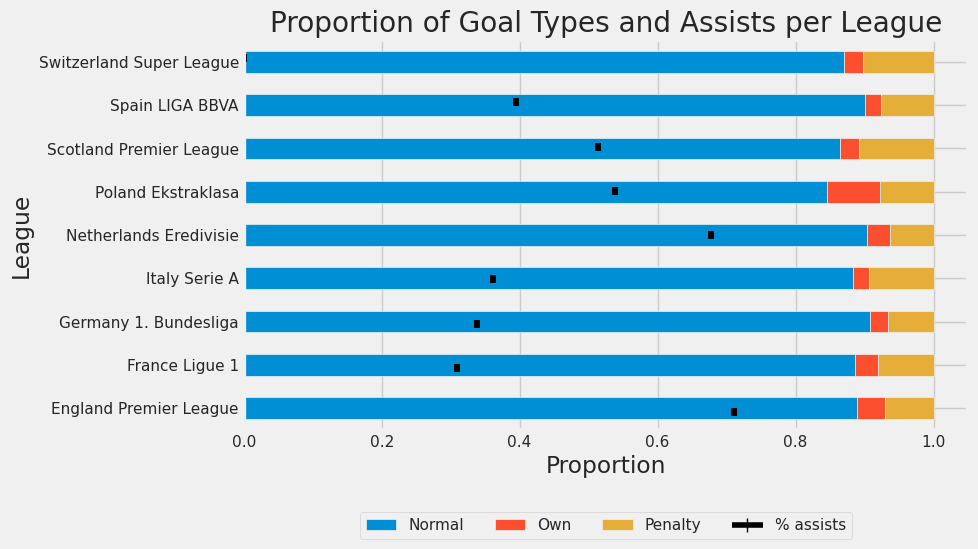

In [12]:
goal_type_legend_labels = {
    "n": "Normal",
    "p": "Penalty",
    "o": "Own",
}

# Calculate goal type proportions
goal_types = goals_info_df.groupby(["league_name", "goal_type"]).size()
goal_types = (
    goal_types.groupby(level=0, group_keys=False)
    .apply(lambda x: x / float(x.sum()))
    .reset_index(name="proportion")
)

# Calculate assist proportions
goals_info_df["assist_present"] = goals_info_df["assist_player_id"].notna()
assist_proportion = (
    goals_info_df.groupby("league_name")["assist_present"]
    .mean()
    .reset_index(name="assist_proportion")
)

# Merge the datasets
combined_df = pd.merge(goal_types, assist_proportion, on="league_name")

# Normalize data for stacked plotting
pivot_df = combined_df.pivot(
    index="league_name", columns="goal_type", values="proportion"
)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

importlib.reload(graph)
graph.render_goal_type_plot(
    pivot_df=pivot_df,
    combined_df=combined_df,
    goal_type_legend_labels=goal_type_legend_labels,
)

The distribution of types goals scored in all leagues. The difference in total number of penalties can be probably explained by different strictiness of referees etc. and random variance. The number of own goals seems to be significantly higher in Poland. Additional research might be neccesary to explain this (unless there are issues with data quality).

The wildly different proportion of goals that a have an assist associated with them is likely due to issues in data quality and is not tracked consistently across all leagues.  

In [13]:
# Explode 'all_players_in_game' to create player-match combinations
# goals data only include players who have scored goals.
player_league = data.matches_df.explode("all_players_in_game")[
    ["all_players_in_game", "league_name"]
]
player_league.rename(columns={"all_players_in_game": "player_id"}, inplace=True)

player_league_grouped = (
    player_league.groupby(["player_id", "league_name"])
    .size()
    .reset_index(name="matches_played")
)

player_goals = (
    goals_info_df.groupby(["scoring_player_id", "league_name"])
    .size()
    .reset_index(name="goals")
)

player_league_goals = pd.merge(
    player_league_grouped,
    player_goals,
    left_on=["player_id", "league_name"],
    right_on=["scoring_player_id", "league_name"],
    how="left",
).fillna(0)

player_league_goals.drop(columns="scoring_player_id", inplace=True)

player_league_goals = pd.merge(
    player_league_goals,
    data.player_df[["player_api_id", "player_name"]],
    left_on="player_id",
    right_on="player_api_id",
    how="left",
)
player_league_goals.drop(columns="player_api_id", inplace=True)

if VERBOSE:
    player_league_goals

In [14]:
thresholds_config = [
    ("top_1", "Top 1%", 0.01),
    ("top_5", "Top 1-5%", 0.05),
    ("top_50", "Top 5-10%", 0.1),
    ("remaining", "Remaining %", 1),
]

league_player_goals = (
    player_league_goals.groupby(["league_name", "player_id"])
    .agg({"goals": "sum"})
    .reset_index()
)

league_player_goals.sort_values(
    by=["league_name", "goals"], ascending=[True, False], inplace=True
)

league_player_goals["cumulative_goals"] = league_player_goals.groupby("league_name")[
    "goals"
].cumsum()
league_player_goals["player_rank"] = (
        league_player_goals.groupby("league_name").cumcount() + 1
)

total_goals_by_league = league_player_goals.groupby("league_name")["goals"].sum()
total_players_by_league = league_player_goals.groupby("league_name")[
    "player_id"
].nunique()

thresholds = total_players_by_league.apply(
    lambda x: pd.Series({key: int(val * x) for key, name, val in thresholds_config})
).astype(int)


def calculate_percentages(league):
    league_data = league_player_goals[league_player_goals["league_name"] == league]
    percentages = {}
    last_threshold = 0
    total_goals = total_goals_by_league[league]

    for key, label, val in thresholds_config:
        if key != "remaining":
            threshold = thresholds.loc[league, key]
            goals_at_threshold = league_data[league_data["player_rank"] <= threshold][
                "cumulative_goals"
            ].iloc[-1]
            percentages[label] = (goals_at_threshold - last_threshold) / total_goals
            last_threshold = goals_at_threshold
        else:
            percentages[label] = 1 - sum(percentages.values())

    return pd.Series(percentages)


proportions = pd.DataFrame(
    {league: calculate_percentages(league) for league in total_goals_by_league.index}
)
proportions = proportions[
    [
        c
        for c in proportions.columns
        if not ("Scotland" in c or "Belgium" in c or "Poland" in c or "Portugal" in c)
    ]
]

/tmp/ipykernel_17118/1727508686.py:47: RuntimeWarning: invalid value encountered in scalar divide
  percentages[label] = (goals_at_threshold - last_threshold) / total_goals
/tmp/ipykernel_17118/1727508686.py:47: RuntimeWarning: invalid value encountered in scalar divide
  percentages[label] = (goals_at_threshold - last_threshold) / total_goals


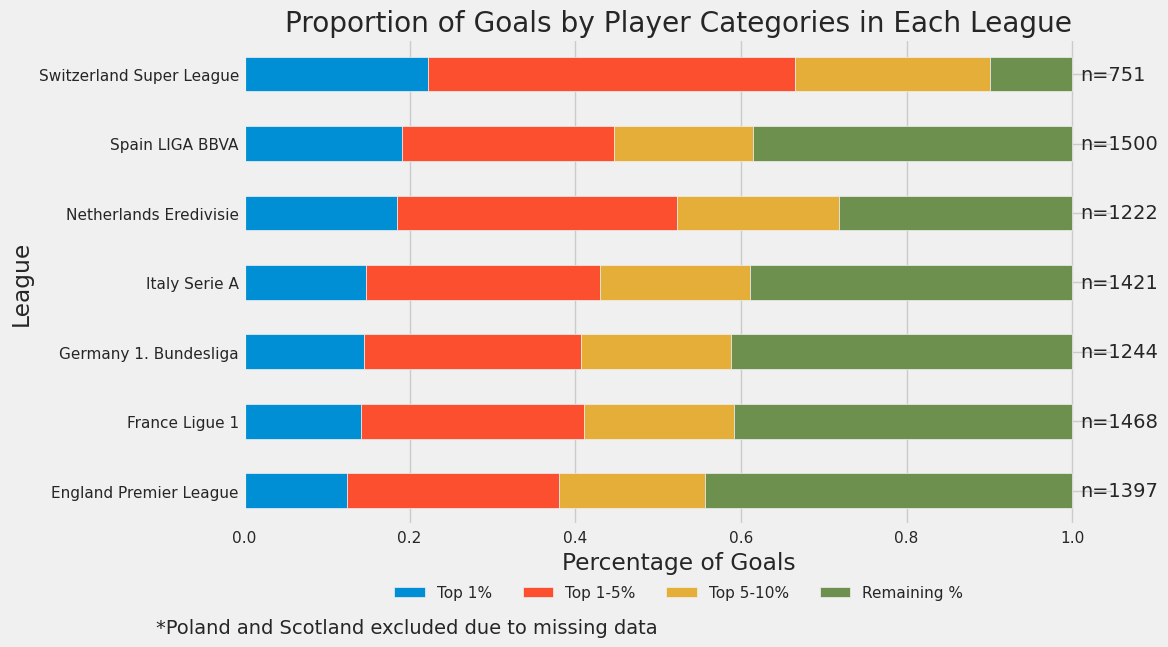

In [15]:
importlib.reload(graph)
graph.plot_player_goal_inequality(proportions, total_players_by_league)

The chart allows us to compare the 'inequality' of goal scoring across different leagues. For instance, we can see that the top 1% of goal scorers score only ~10% of goals in England but this increases to ~22% in Switzerland. Based on this we can assume the at least the amongst goal scoring players the differences in player skill is much lower in some leagues than in other (where most games are dominated by a smaller proportion of gaol scorers).

In [16]:
player_league_goals_s = player_league_goals.copy()
player_league_goals_s["mean_goals"] = (
        player_league_goals_s["goals"] / player_league_goals_s["matches_played"]
)

player_league_goals_s["goals_norm"] = player_league_goals_s["goals"].map(
    lambda v: v if v < 150 else 150
)
player_league_goals_s["matches_played_norm"] = player_league_goals_s[
    "matches_played"
].map(lambda v: v if v < 100 else 100)

player_league_goals_s = player_league_goals_s[
    player_league_goals_s["matches_played"] > 4
    ]
bins = [-1, 0, 5, 10, float("inf")]
labels = ["0", "1-5", "5-10", "10+"]

player_league_goals_s["goal_bins"] = pd.cut(
    player_league_goals_s["goals"], bins=bins, labels=labels
)

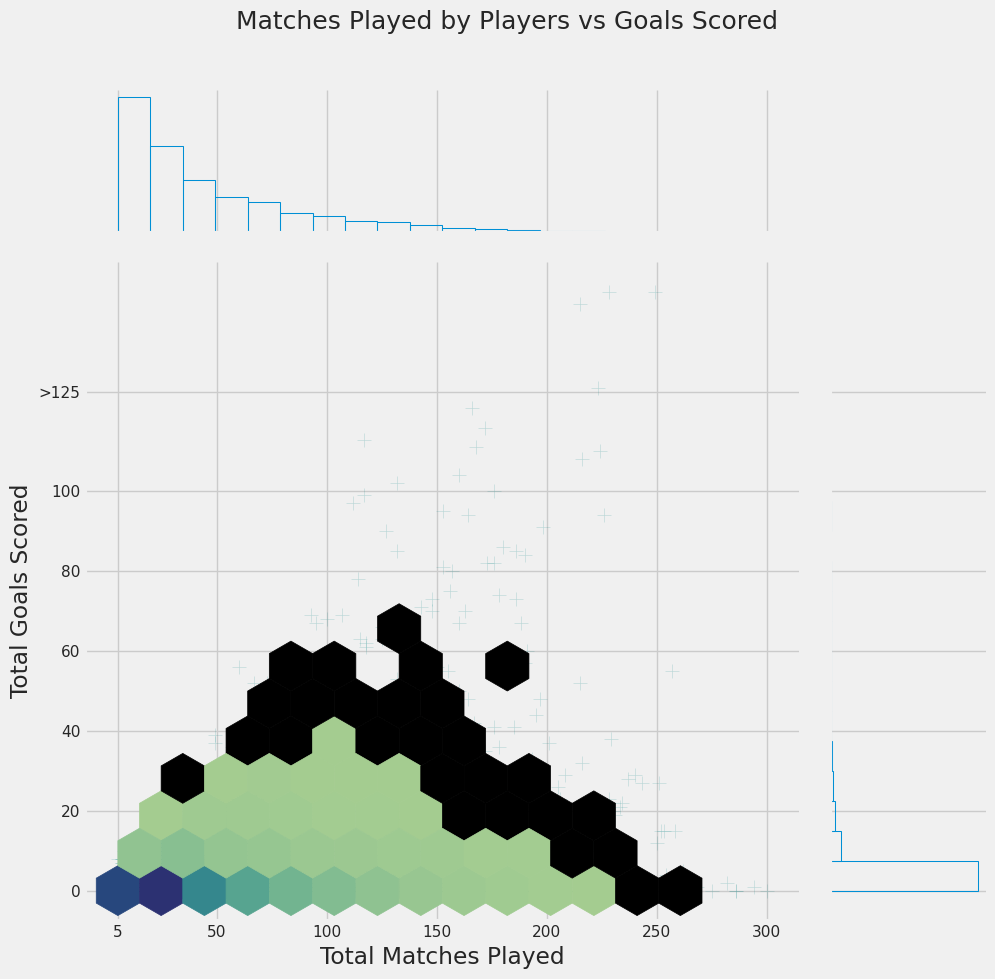

In [103]:
g = sns.JointGrid(
    data=player_league_goals_s,
    x="matches_played",
    y="goals_norm",
    height=10,
    ratio=4,
)

g.ax_joint.scatter(
    player_league_goals_s["matches_played"],
    player_league_goals_s["goals_norm"],
    color="teal",
    marker="+",
    alpha=0.2,
    s=100,
    linewidth=0.5,  # thickness of the lines in the marker
)

g.ax_joint.hexbin(
    player_league_goals_s["matches_played"],
    player_league_goals_s["goals_norm"],
    gridsize=15,
    mincnt=5,
    cmap=custom_cmap,
    alpha=1,
)

g.plot_marginals(sns.histplot, bins=20, fill=False)

custom_x_ticks = [5, 50, 100, 150, 200, 250, 300]
custom_x_labels = [5, 50, 100, 150, 200, 250, 300]

custom_y_ticks = [0, 20, 40, 60, 80, 100, 125]
custom_y_labels = [0, 20, 40, 60, 80, 100, ">125"]

g.ax_joint.set_xticks(custom_x_ticks)
g.ax_joint.set_xticklabels(custom_x_labels)

g.ax_joint.set_yticks(custom_y_ticks)
g.ax_joint.set_yticklabels(custom_y_labels)

g.fig.suptitle("Matches Played by Players vs Goals Scored", fontsize=18)
# plt.figtext(0.5, 0.025, "Your annotation here", ha="center", fontsize=12)

g.fig.subplots_adjust(top=0.9)
g.set_axis_labels("Total Matches Played", "Total Goals Scored")

This chart show the relationship in goals scored by individual players in relation to the number of matches they have played. 

Text(0.5, 1.0, 'Matches Count by Player ')

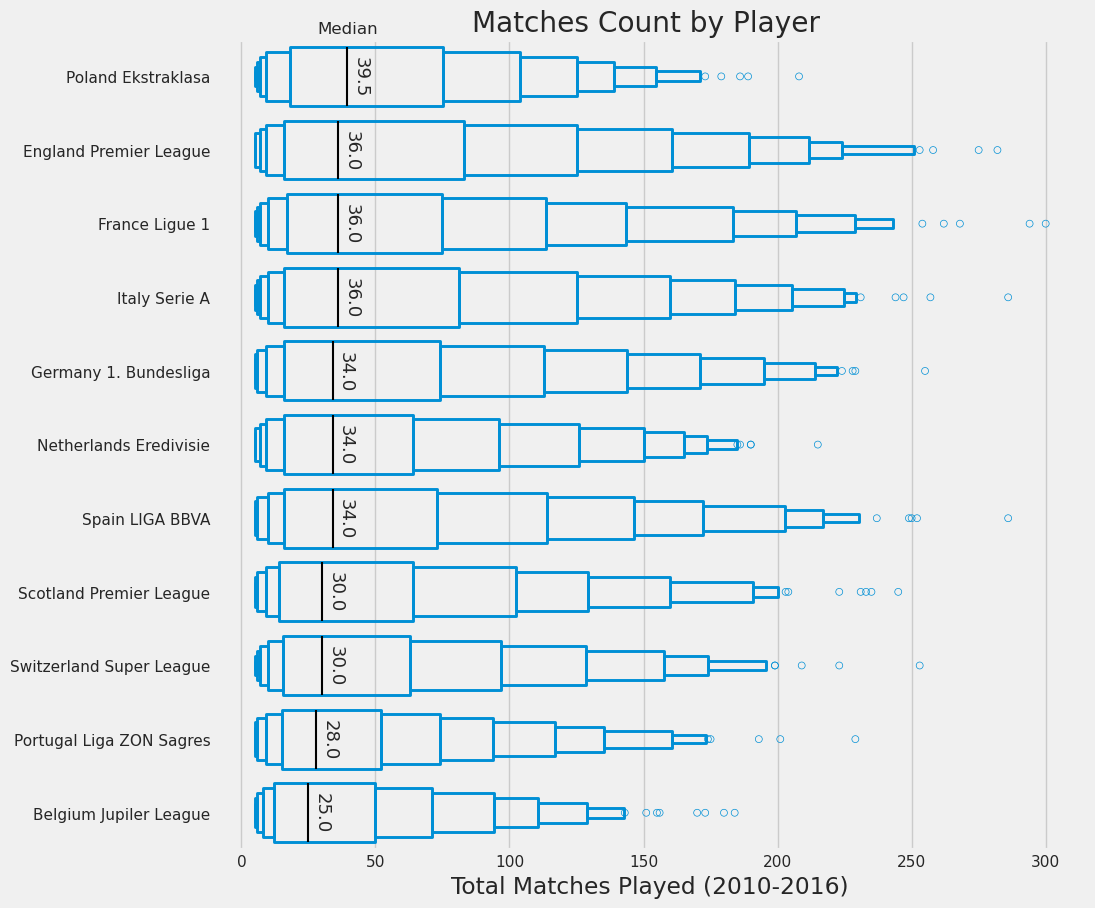

In [18]:
plt.figure(figsize=(10, 10))  # Increase size

league_names = player_league_goals_s

league_names_sorted = (
    player_league_goals_s.groupby("league_name")["matches_played"]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# sns.violinplot(data=player_league_goals_s, x="matches_played", y="league_name", orient="y", fill=False, linewidth=1.1)


# plt.xscale('log', base=1.2)  # Set X-axis to logarithmic scale, chage base as needed
plt.xlabel("Total Matches Played (2010-2016)")  # Change X-axis label
# custom_ticks = [1, 10, 100, 150]  # Define custom tick positions
# custom_labels = ["1", "10", "100", "1000"]  # Define custom tick labels
# plt.xticks(custom_ticks, custom_labels)  # Set custom ticks
ax = sns.boxenplot(
    k_depth="tukey",
    fill=False,
    linewidth=2.1,
    data=player_league_goals_s,
    x="matches_played",
    y="league_name",
    orient="y",
    # color="b",
    line_kws=dict(linewidth=1.5, color="black"),
    order=league_names_sorted,
    width_method="linear",
)
for i, league in enumerate(league_names_sorted):
    median = player_league_goals_s[player_league_goals_s["league_name"] == league][
        "matches_played"
    ].median()
    if i == 0:
        ax.text(
            median,
            i - 0.65,
            f"Median",
            ha="center",
            va="center",
            fontsize=12,
            # rotation=270,
        )

    ax.text(
        median + 5,
        i,
        f"{median}",
        ha="center",
        va="center",
        fontsize=13,
        rotation=270,
    )

plt.xlabel("Total Matches Played (2010-2016)")  # Change X-axis label
plt.ylabel("\n")  # Change X-axis label
plt.title("Matches Count by Player ")  # Add title

/tmp/ipykernel_17118/3368172736.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 100])


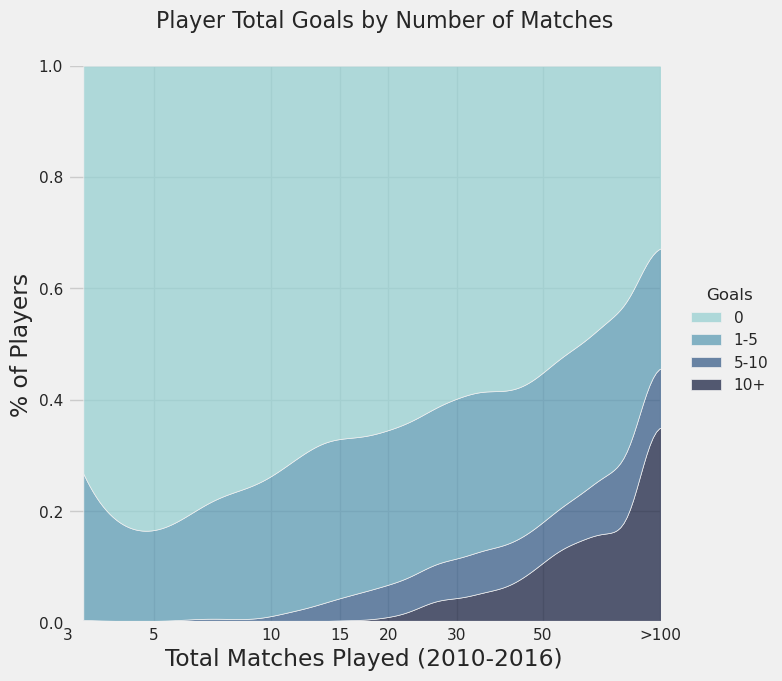

In [19]:
g2 = sns.displot(
    data=player_league_goals_s,
    x="matches_played_norm",
    hue="goal_bins",
    kind="kde",
    # rug=True,
    # rug_kws = dict(expand_margins=True, height=0.1, lw=0.01),
    # kwargs = dict(cumulative=False),
    # kind="kde",
    height=7,
    log_scale=[5, None],
    multiple="fill",
    clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

custom_x_ticks_dist = [3, 5, 10, 15, 20, 30, 50, 100]
custom_x_labels_dist = [3, 5, 10, 15, 20, 30, 50, ">100"]

for ax in g2.axes.ravel():
    ax.set_xticks(custom_x_ticks_dist)
    ax.set_xticklabels(custom_x_labels_dist)
    ax.set_xlim([0, 100])

g2.fig.suptitle("Player Total Goals by Number of Matches", fontsize=16)
g2.fig.subplots_adjust(top=0.9)
plt.xlabel("Total Matches Played (2010-2016)")  # Change X-axis label
plt.ylabel("% of Players")  # Change X-axis label
g2.legend.set_title("Goals")

plt.show()

This chart shows the proportion of players who have scored goals in relation to the number of matches they have played in. We can see that around 30% of players who have played 100 games or more still have scored any goals. In addition to goalkeepers this probably included a signifcant proportion of defenders who tend to not score many goals.

#### Season Points Analysis

In [20]:
temp = full_df.sort_values(by=["team_id", "season_start_year", "stage"])
last_games = temp.loc[
    full_df.groupby(["team_id", "season_start_year"])["stage"].idxmax()
]
if VERBOSE:
    last_games

In [21]:
if VERBOSE:
    last_games["league_name"].value_counts()

In [22]:
pl_2015 = last_games[
    (last_games["league_name"] == "England Premier League")
    & (last_games["season_start_year"] == 2015)
    ]
league_last_games = last_games[
    [
        "team_id",
        "stage",
        "team_team_long_name",
        "cumulative_points",
        "league_name",
        "season_start_year",
        "team_rating",
    ]
]

league_last_games.sort_values(
    by=["league_name", "season_start_year", "cumulative_points"], ascending=False
)

league_last_games["normalized_points"] = league_last_games["cumulative_points"] / (
        league_last_games["stage"] * 3
)

winners = league_last_games.groupby(["league_name", "season_start_year"])[
    "cumulative_points"
].idxmax()
top_4_indices = (
    league_last_games.groupby(["league_name", "season_start_year"])["cumulative_points"]
    .nlargest(4)
    .reset_index(level=[0, 1], drop=True)
    .index
)

league_last_games["won_season"] = False
league_last_games.loc[winners, "won_season"] = True

league_last_games["top_4"] = False
league_last_games.loc[top_4_indices, "top_4"] = True

# team_rating is only for a specific game, we need to get the season average
avg_season_team_rating = (
    full_df.groupby(by=["team_id", "season_start_year"])["team_rating"]
    .mean()
    .reset_index()
    .rename(columns={"team_rating": "avg_season_team_rating"})
)

league_last_games = league_last_games.merge(
    avg_season_team_rating, on=["team_id", "season_start_year"]
)

/tmp/ipykernel_17118/1595024916.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_last_games["normalized_points"] = league_last_games["cumulative_points"] / (
/tmp/ipykernel_17118/1595024916.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_last_games["won_season"] = False
/tmp/ipykernel_17118/1595024916.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [23]:
def gini_coefficient(points):
    n = len(points)
    points_sorted = sorted(points)
    index = range(1, n + 1)
    numerator = sum((n + 1 - i) * y for i, y in zip(index, points_sorted))
    gini = (n + 1 - 2 * numerator / sum(points_sorted)) / n
    return gini


league_year_gini = (
    league_last_games.groupby(["league_name", "season_start_year"])["cumulative_points"]
    .agg(gini_coefficient)
    .reset_index()
)
league_year_gini.rename(columns={"cumulative_points": "gini_coefficient"}, inplace=True)

league_aggregated = (
    league_last_games.groupby("league_name")["cumulative_points"]
    .agg(list)
    .reset_index()
)

league_aggregated["gini_coefficient"] = league_aggregated["cumulative_points"].apply(
    gini_coefficient
)

league_aggregated.drop(columns=["cumulative_points"], inplace=True)
if VERBOSE:
    league_year_gini

In [24]:
grouped = league_last_games.groupby(["league_name", "season_start_year"])


def league_metrics(group):
    sorted_group = group.sort_values(by="cumulative_points", ascending=False)
    top_5 = sorted_group.head(5)
    bottom_5 = sorted_group.tail(5)
    return pd.Series(
        {
            "total_teams": group["team_team_long_name"].nunique(),
            "bottom_5_to_top_5_proportion": bottom_5["cumulative_points"].sum()
                                            / top_5["cumulative_points"].sum(),
            "gap_top1_top2": sorted_group.iloc[0]["cumulative_points"]
                             - sorted_group.iloc[1]["cumulative_points"],
            "closeness_top_5": top_5["cumulative_points"].std(),
            "std_dev_points": group["cumulative_points"].std(),
        }
    )


league_year_metrics = grouped.apply(league_metrics)


def gini_coefficient(points):
    n = len(points)
    points_sorted = sorted(points)
    index = range(1, n + 1)
    numerator = sum((n + 1 - i) * y for i, y in zip(index, points_sorted))
    gini = (n + 1 - 2 * numerator / sum(points_sorted)) / n
    return gini


league_year_gini = league_year_metrics.assign(
    gini_coefficient=grouped["cumulative_points"].apply(gini_coefficient)
)

if VERBOSE:
    league_year_gini

In [25]:
if VERBOSE:
    importlib.reload(graph)
    graph.render_dist_swarm_plot(league_last_games)

### Team Performance Analysis

/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

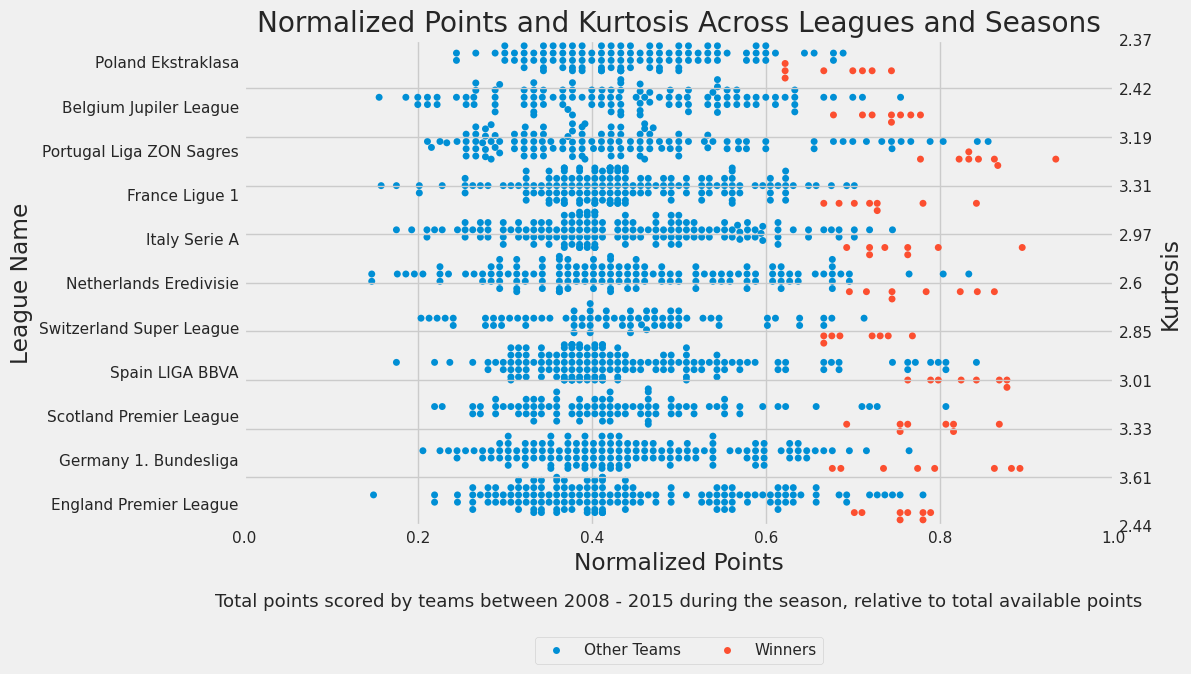

In [26]:
importlib.reload(graph)
graph.render_dist_kurtosis_swarm_plot(league_last_games)

This chart show the distributions of teams by the number of points collected at the end of the season. The Kurtosis value indicates the tails of the distribution and the number of outliers (high Kurtosis means that there are many teams in league which score much more or much less points than most other teams).

We can see that the Polish, English and Belgian leagues are the most equal in performance. While the Portuguese league was dominated by a small number of teams in all the seasons included in the dataset.

In [27]:
if VERBOSE:
    # Which team in the EPL received almost no points?
    league_last_games[
        league_last_games["league_name"] == "England Premier League"
        ].sort_values(by=["normalized_points"])

In [28]:
if VERBOSE:
    league_last_games[
        league_last_games["league_name"] == "Portugal Liga ZON Sagres"
        ].sort_values(by=["normalized_points"], ascending=False)
    league_last_games[league_last_games["league_name"] == "England Premier League"][
        "cumulative_points"
    ].tolist()

In [29]:
if VERBOSE:
    leicsert_Game = data.goals_df[data.goals_df["match_api_id"] == 1987598]
    leicsert_Game
    leicsert_Game = leicsert_Game.merge(
        data.player_df[["player_api_id", "player_name"]],
        left_on="scoring_player_id",
        right_on="player_api_id",
        how="left",
    ).drop("player_api_id", axis=1)
    leicsert_Game

In [30]:
if VERBOSE:
    leicsert_Game.merge(
        full_df[["match_api_id", "league_name", "team_id", "team_team_long_name"]],
        how="left",
        on=["team_id", "match_api_id"],
    )

In [31]:
importlib.reload(data_process)
goals_info_df = data_process.process_goal_info(data, full_df)
if VERBOSE:
    matches_df_short = data.matches_df_short.copy()
    matches_df_short["total_goals"] = (
            data.matches_df_short["home_team_goal"]
            + data.matches_df_short["away_team_goal"]
    )
    matches_df_short["total_goals"].sum()

In [32]:
goals_found_summary = (
    goals_info_df.groupby(["match_api_id"])["match_api_id"]
    .count()
    .to_frame()
    .rename(columns={"match_api_id": "found_goals"})
    .reset_index()
)

goals_verify = matches_df_short[
    ["match_api_id", "league_name", "home_team_goal", "away_team_goal", "total_goals"]
].merge(goals_found_summary, how="left", on="match_api_id")
goals_verify["found_goals"] = goals_verify["found_goals"].fillna(0)

if VERBOSE:
    goals_verify.groupby(["league_name"]).sum()

In [33]:
if VERBOSE:
    goals_verify[
        (goals_verify["total_goals"] != goals_verify["found_goals"])
        & (goals_verify["league_name"] == "England Premier League")
        ]

In [34]:
if VERBOSE:
    data.goals_df[data.goals_df["match_api_id"] == 489229]
    data.matches_df[data.matches_df["match_api_id"] == 489229]["goal"].iloc[0]
    data.matches_df[data.matches_df["match_api_id"] == 489229]

### Team Rating

The "Team Rating" is the sum of all the individual player ratings (based on EA FIFA games) in every match.

### Team Rating vs Team Position at the End of Season

In [35]:
# Ratings for Polish Teams are mostly missing
league_last_games_for_ratings = league_last_games[
    league_last_games["league_name"] != "Poland Ekstraklasa"
    ]

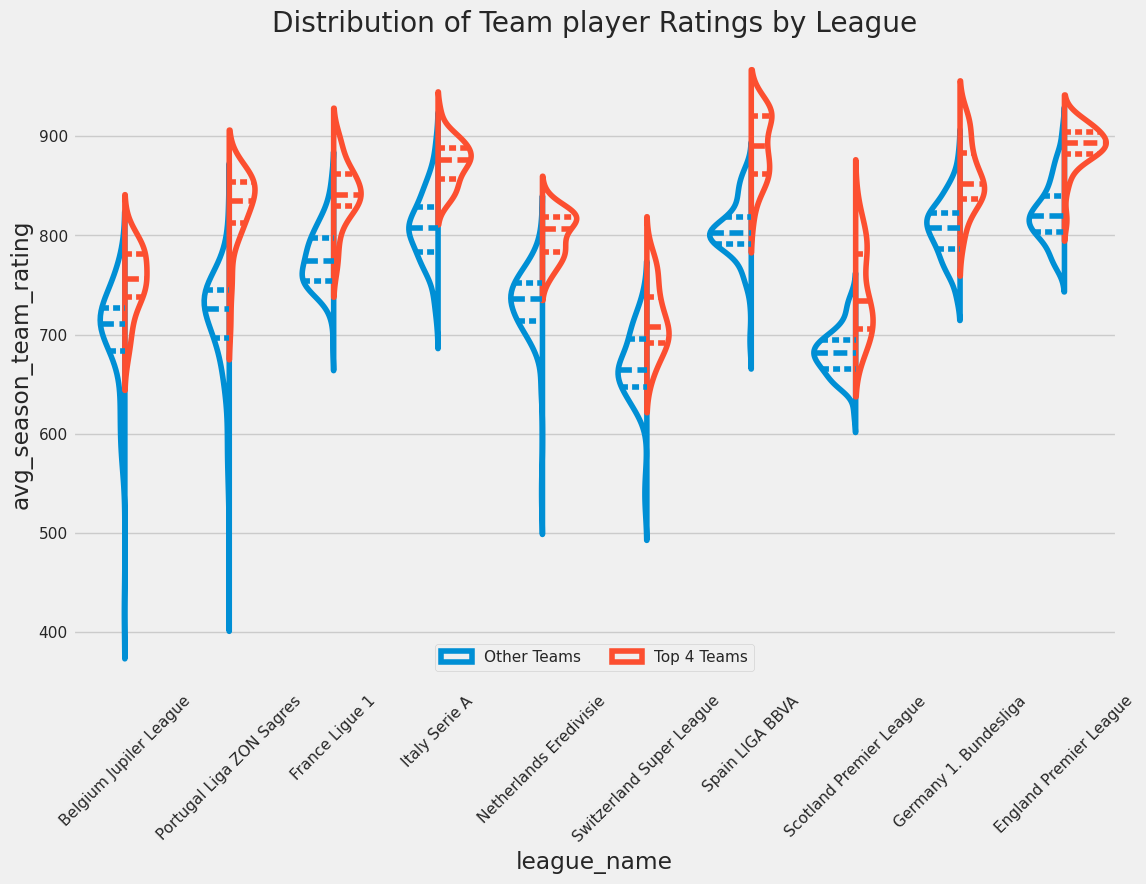

In [36]:
importlib.reload(graph)
graph.render_dist_plot(league_last_games_for_ratings)

Generally teams that have higher ratings tend to dominate most of the leagues. This indicate that it might be a somewhat accurate at predicting the result of matches at least on average over the entire season.

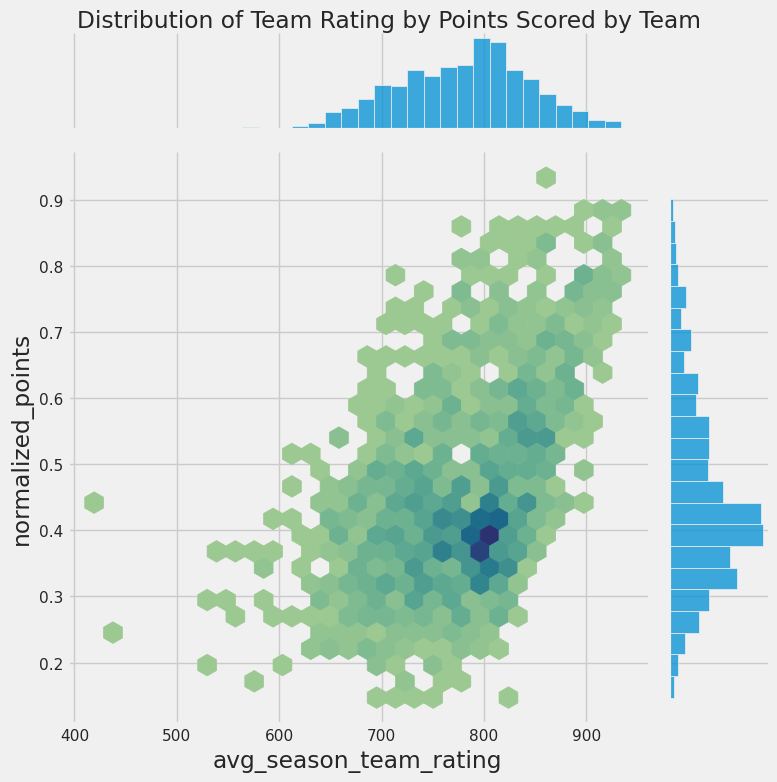

In [73]:
p = sns.jointplot(
    data=league_last_games_for_ratings,
    x="avg_season_team_rating",
    y="normalized_points",
    kind="hex",
    height=8,
    cmap=custom_cmap,
)

p.fig.suptitle("Distribution of Team Rating by Points Scored by Team")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)  # Reduce plot to make room


/tmp/ipykernel_17118/2216064224.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean, std = groups.transform("mean"), groups.transform("std")
/tmp/ipykernel_17118/2216064224.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean, std = groups.transform("mean"), groups.transform("std")


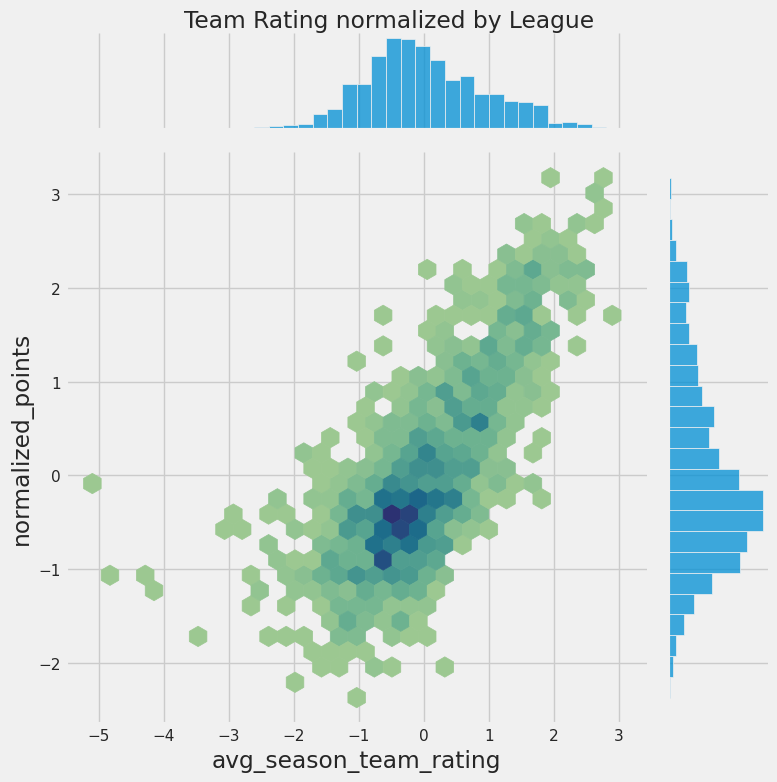

In [74]:
groups = league_last_games_for_ratings.groupby("league_name")
mean, std = groups.transform("mean"), groups.transform("std")
league_last_games_normalized = (
                                       league_last_games_for_ratings[mean.columns] - mean
                               ) / std

p = sns.jointplot(
    data=league_last_games_normalized,
    x="avg_season_team_rating",
    y="normalized_points",
    kind="hex",
    height=8,
    cmap=custom_cmap,
)

p.fig.suptitle("Team Rating normalized by League")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)  # Reduce plot to make room

league_last_games_normalized["league_name"] = league_last_games_for_ratings[
    "league_name"
]

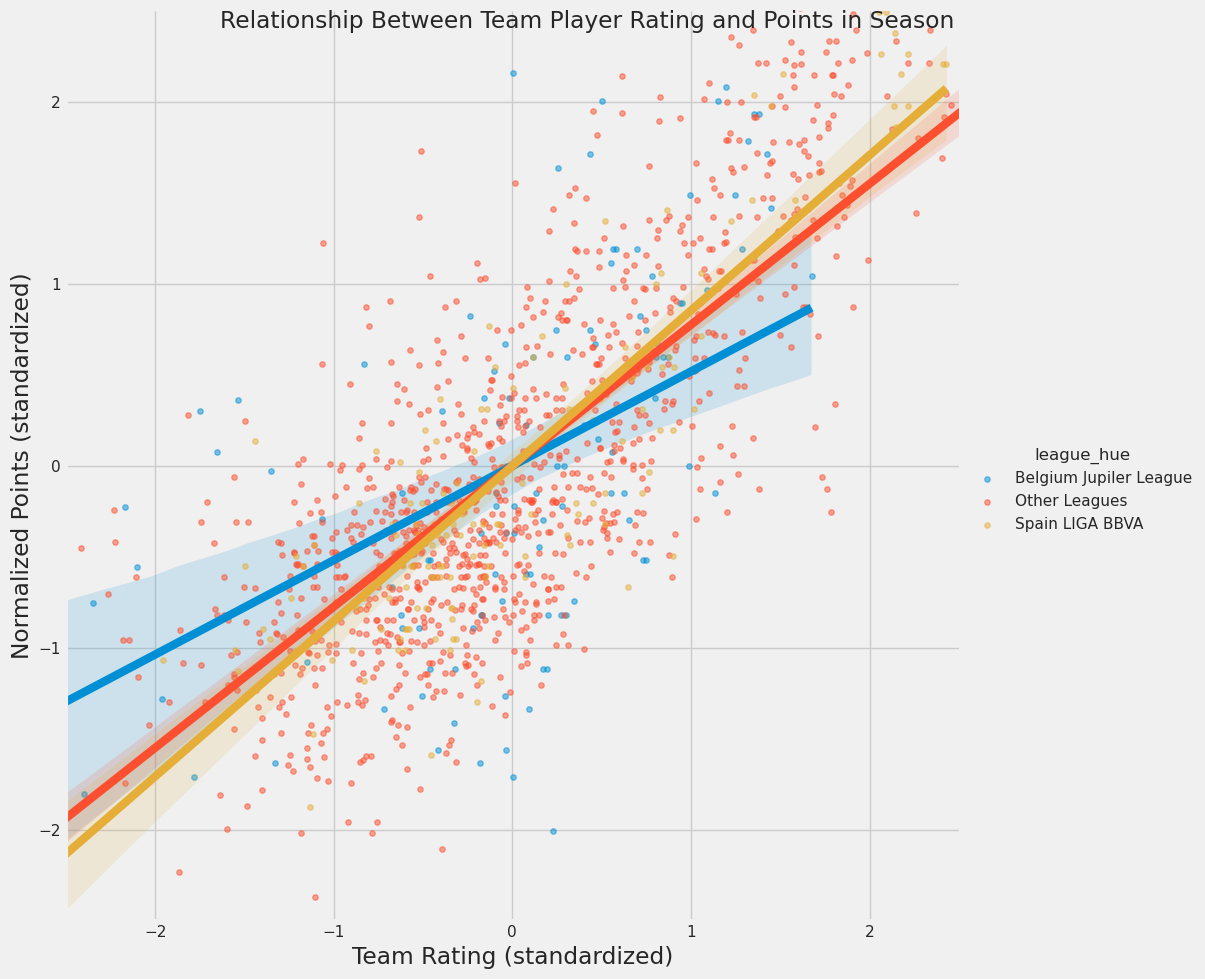

In [39]:
corr_map = (
    league_last_games_normalized.groupby("league_name")[
        ["avg_season_team_rating", "normalized_points"]
    ]
    .corr()
    .reset_index()
)

corr_map = (
    corr_map[corr_map["level_1"] != "avg_season_team_rating"]
    .drop(columns=["normalized_points"])
    .sort_values(by="avg_season_team_rating", ascending=False)
)
selected_leagues = corr_map.iloc[[0, -1]]["league_name"].tolist()

league_last_games_normalized["league_hue"] = league_last_games_for_ratings[
    "league_name"
].map(lambda l: l if l in selected_leagues else "Other Leagues")

g = sns.lmplot(
    data=league_last_games_normalized,
    x="avg_season_team_rating",
    y="normalized_points",
    hue="league_hue",
    height=10,
    scatter_kws={"s": 15, "alpha": 0.5},
)

g.ax.set_ylim([-2.5, 2.5])
g.ax.set_xlim([-2.5, 2.5])
g.fig.suptitle("Relationship Between Team Player Rating and Points in Season")

g.set_axis_labels("Team Rating (standardized)", "Normalized Points (standardized)")

### Change in Team Rating Over Season

In [40]:
temp = full_df[
    ["league_name", "season_start_year", "stage", "cumulative_points", "team_rating"]
].sort_values(by=["stage"])

In [75]:
temp = full_df[
    ["league_name", "season_start_year", "stage", "cumulative_points", "team_rating"]
].sort_values(by=["stage"])


def top_bottom_mean_normalized(group):
    normalized_rating = (group["team_rating"] - group["team_rating"].min()) / (
            group["team_rating"].max() - group["team_rating"].min()
    )

    normalized_rating = normalized_rating * 1000
    overall_mean = normalized_rating.mean()
    sorted_group = normalized_rating.sort_values()

    n = len(sorted_group)
    top_bottom_n = int(0.20 * n)

    top_mean = sorted_group[-top_bottom_n:].mean()
    bottom_mean = sorted_group[:top_bottom_n].mean()

    return pd.Series(
        {
            "overall_mean_normalized": overall_mean,
            "top_20%_mean_normalized": top_mean,
            "bottom_20%_mean_normalized": bottom_mean,
        }
    )


normalized_results = temp.groupby(["league_name", "stage"]).apply(
    top_bottom_mean_normalized
)

normalized_results = normalized_results.reset_index()
reshaped_data = normalized_results.reset_index()[
    ["league_name", "stage", "overall_mean_normalized"]
]

if VERBOSE:

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=normalized_results, x="stage", y="overall_mean_normalized", hue="league_name"
    )

    for league in normalized_results["league_name"].unique():
        league_data = normalized_results[normalized_results["league_name"] == league]
        plt.fill_between(
            league_data["stage"],
            league_data["top_20%_mean_normalized"],
            league_data["bottom_20%_mean_normalized"],
            alpha=0.2,
        )

    plt.ylim([0, 1000])
    plt.title("Normalized Team Rating Mean with Confidence Intervals by League and Stage")
    plt.xlabel("Stage")
    plt.ylabel("Normalized Rating")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()

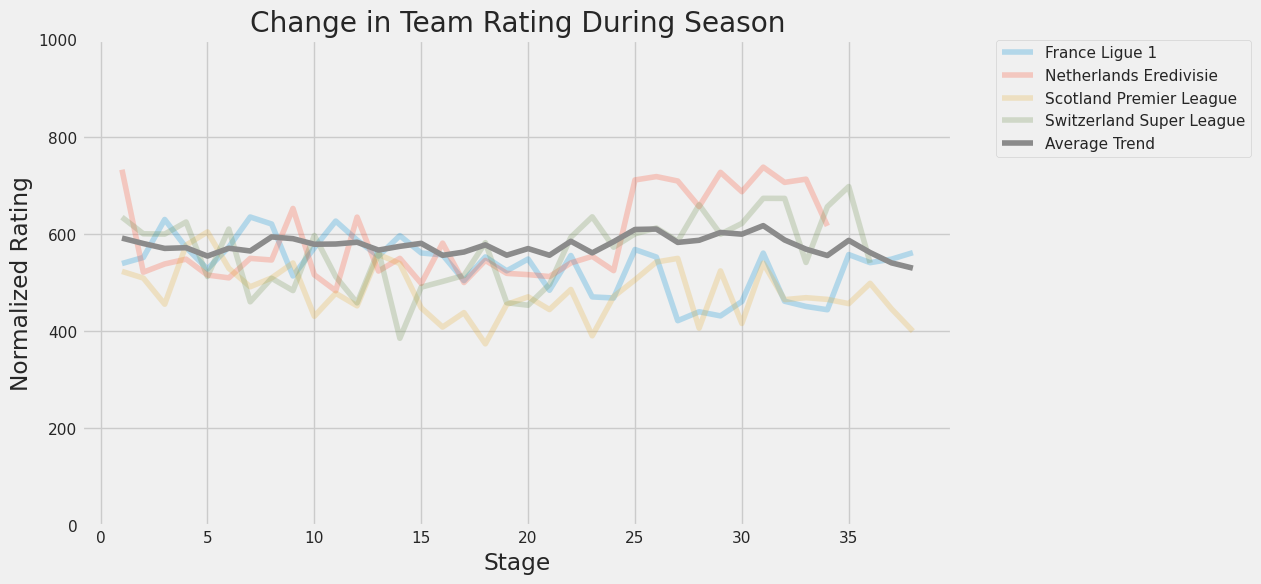

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

normalized_results = temp.groupby(["league_name", "stage"]).apply(
    top_bottom_mean_normalized
)
normalized_results = normalized_results.reset_index()

average_trend = normalized_results.groupby("stage")["overall_mean_normalized"].mean()


def is_significantly_different(league_data, average_trend):
    slope, _, _, p_value, _ = stats.linregress(
        league_data["stage"], league_data["overall_mean_normalized"]
    )
    avg_slope = stats.linregress(average_trend.index, average_trend.values)[0]
    return np.abs(slope - avg_slope) > threshold and p_value < alpha


threshold = 0.1
alpha = 0.05

significant_leagues = []
for league in normalized_results["league_name"].unique():
    league_data = normalized_results[normalized_results["league_name"] == league]
    if is_significantly_different(league_data, average_trend):
        significant_leagues.append(league)

plt.figure(figsize=(10, 6))

for league in significant_leagues:
    league_data = normalized_results[normalized_results["league_name"] == league]
    sns.lineplot(
        data=league_data,
        x="stage",
        y="overall_mean_normalized",
        label=league,
        alpha=0.25,
    )

sns.lineplot(data=average_trend, label="Average Trend")

plt.ylim([0, 1000])
plt.title("Change in Team Rating During Season")
plt.xlabel("Stage")
plt.ylabel("Normalized Rating")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

The chart above shows how the team rating has changed on average in every league during the seasons (over the entire period included in the dataset. The  trend in leagues which are shown individually was signficantly different to the average trend across all the remaining leagues (i.e. slope significantly  different using the p-test).

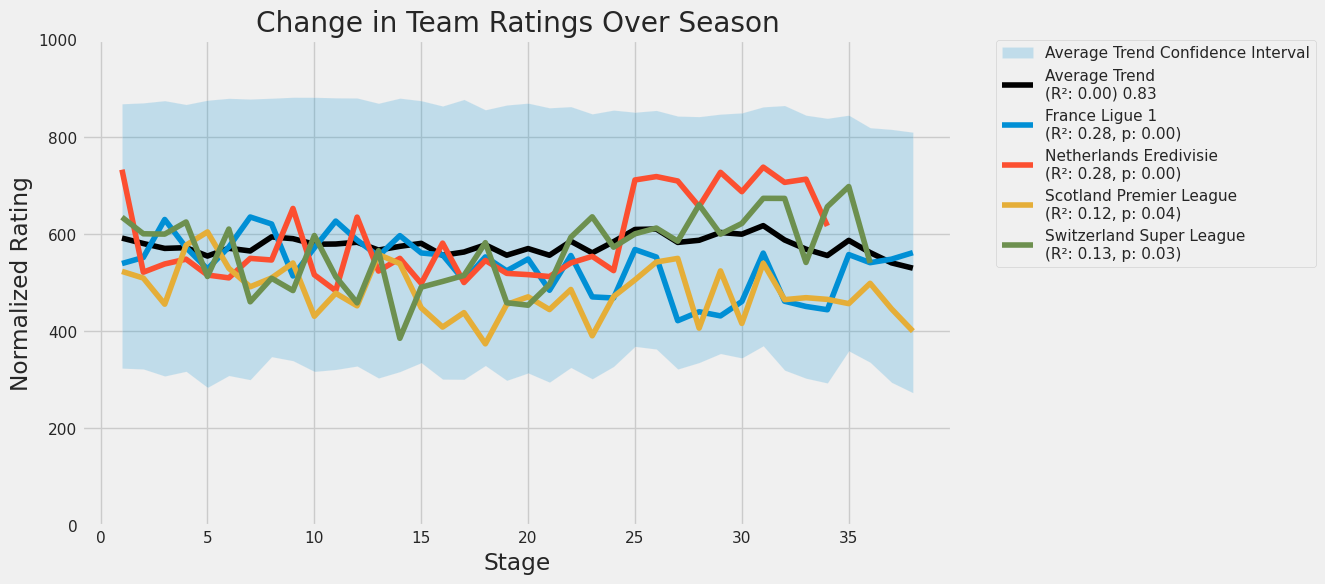

In [43]:
normalized_results = temp.groupby(["league_name", "stage"]).apply(
    top_bottom_mean_normalized
)
normalized_results = normalized_results.reset_index()

average_trend = normalized_results.groupby("stage").agg(
    overall_mean=("overall_mean_normalized", "mean"),
    top_20_mean=("top_20%_mean_normalized", "mean"),
    bottom_20_mean=("bottom_20%_mean_normalized", "mean"),
)


def calc_r2_and_pval(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value ** 2, p_value


significant_leagues = []
alpha = 0.05  # significance level
for league in normalized_results["league_name"].unique():
    league_data = normalized_results[normalized_results["league_name"] == league]
    r2, pval = calc_r2_and_pval(
        league_data["stage"], league_data["overall_mean_normalized"]
    )
    if pval < alpha:
        significant_leagues.append((league, r2, pval))

plt.figure(figsize=(10, 6))

plt.fill_between(
    average_trend.index,
    average_trend["top_20_mean"],
    average_trend["bottom_20_mean"],
    alpha=0.2,
    label="Average Trend Confidence Interval",
)

r2_avg, p_avg = calc_r2_and_pval(average_trend.index, average_trend["overall_mean"])
sns.lineplot(
    data=average_trend,
    x=average_trend.index,
    y="overall_mean",
    label=f"Average Trend\n(R²: {r2_avg:.2f}) {p_avg:.2f}",
    color="black",
)

for league, r2, pval in significant_leagues:
    league_data = normalized_results[normalized_results["league_name"] == league]
    sns.lineplot(
        data=league_data,
        x="stage",
        y="overall_mean_normalized",
        label=f"{league}\n(R²: {r2:.2f}, p: {pval:.2f})",
    )

plt.ylim([0, 1000])
plt.title("Change in Team Ratings Over Season")
plt.xlabel("Stage")
plt.ylabel("Normalized Rating")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

To get a slightly clearer picture we have also shown the bottom and top 20% and 80% percentile normalized ratings across all seasons and all leagues.

In [44]:
team_ratio_ratio_df = full_df[
    ["team_rating", "opponent_team_rating", "league_name", "result"]
]

team_ratio_ratio_df = team_ratio_ratio_df[team_ratio_ratio_df["team_rating"].notna()]
team_ratio_ratio_df["ratio"] = round(
    team_ratio_ratio_df["team_rating"] / team_ratio_ratio_df["opponent_team_rating"], 3
)

std_dev = team_ratio_ratio_df["ratio"].std()
team_ratio_ratio_df["capped_ratio"] = team_ratio_ratio_df["ratio"].clip(
    1 - std_dev * 2, 1 + std_dev * 2
)

In [45]:
if VERBOSE:
    display(team_ratio_ratio_df["ratio"].describe())
    display(team_ratio_ratio_df["capped_ratio"].describe())
    display(team_ratio_ratio_df["ratio"].std())

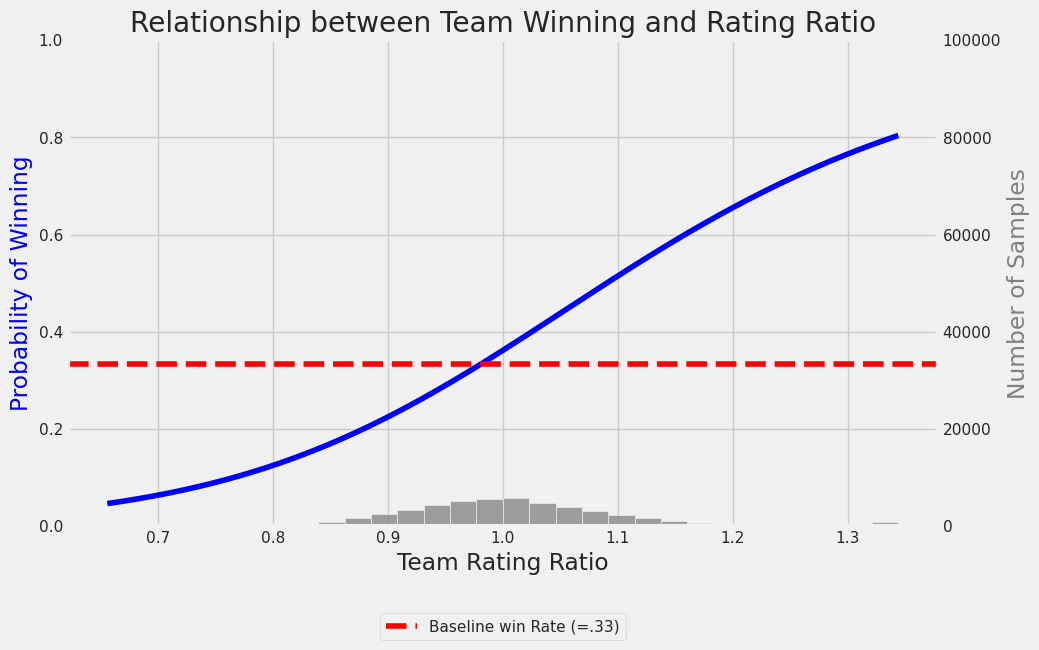

In [46]:
X = team_ratio_ratio_df[["capped_ratio"]].values  # Predictor
y = team_ratio_ratio_df["result"].values  #

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

x_values = np.linspace(min(X), max(X), 300).reshape(-1, 1)
y_values = model.predict_proba(x_values)[:, 2]  # Probability of winning

bins = np.linspace(min(X), max(X), 20)
bin_indices = [np.argmax(x <= bins) - 1 for x in X_test[:, 0]]

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x=x_values.flatten(), y=y_values, ax=ax1, color="blue")

ax1.set_xlabel("Team Rating Ratio")
ax1.set_ylabel("Probability of Winning", color="blue")
ax1.axhline(y=1 / 3, color="red", linestyle="--", label="Baseline win Rate (=.33)")
ax1.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.25))

ax1.set_ylim([0, 1])

mid_points = (bins[:-1] + bins[1:]) / 2

ax2 = ax1.twinx()
sns.histplot(
    team_ratio_ratio_df["capped_ratio"], ax=ax2, color="gray", bins=30, kde=False
)
ax2.set_ylabel("Number of Samples", color="gray")
ax2.grid(False)

ax2.set_ylim([0, 100000])

coef = model.coef_[0][0]

plt.title("Relationship between Team Winning and Rating Ratio")
plt.show()

Our next step was to further examine the relationship between the sum of player ratings and the likelihood of a team with a higher rating winning. This is a simple logistic regression showing the probability of a binary outcome Win - Not Win based on the different in team ratings. We can see that the likelihood of a team which has an at least >30% higher rating is almost 80%. We will expand on this relationship when building our multi-classification model in our next notebook.

#### PCA Analysis

In [84]:
features = (
        feature_select.FeatureSet.Base
        | feature_select.FeatureSet.TeamSeasonStats
        | feature_select.FeatureSet.TeamRatingStats
)

feature_names = feature_select.get_feature_sets(features)
selected_df = full_df[feature_names]

if VERBOSE:
    print("Features used in PCA")
    print(feature_names)

    print("\n--\n")

features_no_nan = selected_df.dropna()

if VERBOSE:
    print(f"Drop NaN {len(selected_df)} -> {len(features_no_nan)} samples")

13


In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_no_nan_std = pd.DataFrame(
    scaler.fit_transform(features_no_nan), columns=features_no_nan.columns
)

In [49]:
from workbench.src import shared

importlib.reload(shared)
_explained_pc = shared.get_pca_explained(features_no_nan_std)
_explained_pc

,var,PC,cum_var
0,0.290852,PC1,0.290852
1,0.266693,PC2,0.557544
2,0.126880,PC3,0.684425
3,0.076688,PC4,0.761113
4,0.065649,PC5,0.826762
5,0.058473,PC6,0.885235
6,0.049256,PC7,0.934491
7,0.028955,PC8,0.963446
8,0.013163,PC9,0.976609
9,0.012951,PC10,0.989560


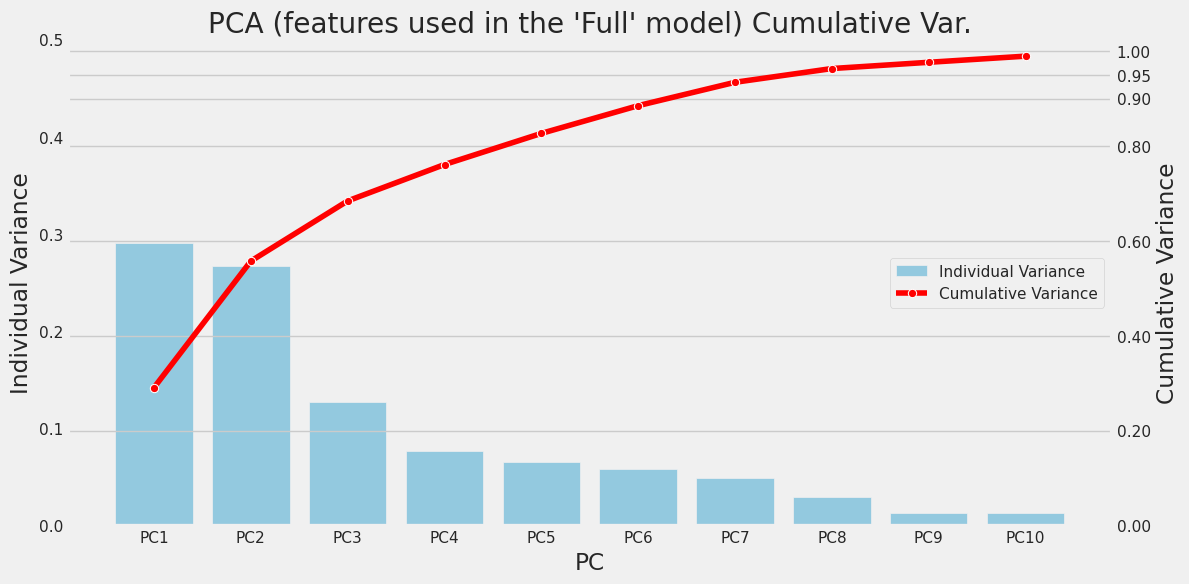

In [89]:
importlib.reload(graph)
graph.render_pca_component_plot(_explained_pc, title="PCA (features used in the 'Full' model) Cumulative Var.")

We have attempted to use PCA to determine whether we can simplify our models by reducing the number of features while retaining most of the variance.

When all the of the features which will be used in our full mode (see `TabularModel.ipynb`) we need to have about 8 components to keep at least 95% of all variance, considering that we only have 13 features in total this doesn't seem like reasonable approach. 

In [51]:
data.team_attrs_df

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,days_after_first_date,team_long_name,league_id,id_x,id_y,country_id,league_name
1112,1113,874,1601,2010-02-22,30,Slow,NaN,Little,40,Mixed,Organised,50,Normal,35,Normal,70,Lots,Organised,65,Medium,60,Press,50,Normal,Cover,584,Ruch Chorzów,15722,120,15722,15722,Poland Ekstraklasa
1113,1114,874,1601,2011-02-22,48,Balanced,NaN,Little,51,Mixed,Organised,68,Risky,67,Lots,51,Normal,Organised,46,Medium,48,Press,50,Normal,Cover,949,Ruch Chorzów,15722,120,15722,15722,Poland Ekstraklasa
1114,1115,874,1601,2012-02-22,53,Balanced,NaN,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1314,Ruch Chorzów,15722,120,15722,15722,Poland Ekstraklasa
1115,1116,874,1601,2013-09-20,53,Balanced,NaN,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,1890,Ruch Chorzów,15722,120,15722,15722,Poland Ekstraklasa
1116,1117,874,1601,2014-09-19,53,Balanced,48.0,Normal,38,Mixed,Organised,66,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,2254,Ruch Chorzów,15722,120,15722,15722,Poland Ekstraklasa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,69,112513,158085,2014-09-19,69,Fast,66.0,Normal,39,Mixed,Organised,55,Normal,59,Normal,46,Normal,Organised,35,Medium,37,Press,37,Normal,Cover,2254,FC Arouca,17642,49,17642,17642,Portugal Liga ZON Sagres
69,70,112513,158085,2015-09-10,65,Balanced,66.0,Normal,39,Mixed,Organised,55,Normal,59,Normal,46,Normal,Organised,37,Medium,39,Press,37,Normal,Cover,2610,FC Arouca,17642,49,17642,17642,Portugal Liga ZON Sagres
274,275,112409,208931,2014-09-19,32,Slow,46.0,Normal,31,Short,Organised,47,Normal,36,Normal,54,Normal,Organised,46,Medium,44,Press,51,Normal,Cover,2254,Carpi,10257,19,10257,10257,Italy Serie A
275,276,112409,208931,2015-09-10,80,Fast,45.0,Normal,65,Mixed,Organised,70,Risky,40,Normal,50,Normal,Organised,25,Deep,55,Press,35,Normal,Cover,2610,Carpi,10257,19,10257,10257,Italy Serie A


#### Team Attributes PCA

In [95]:
team_styles = [
    "buildUpPlaySpeed",
    "buildUpPlaySpeedClass",
    "buildUpPlayDribbling",
    "buildUpPlayDribblingClass",
    "buildUpPlayPassing",
    "buildUpPlayPassingClass",
    "buildUpPlayPositioningClass",
    "chanceCreationPassing",
    "chanceCreationPassingClass",
    "chanceCreationCrossing",
    "chanceCreationCrossingClass",
    "chanceCreationShooting",
    "chanceCreationShootingClass",
    "chanceCreationPositioningClass",
    "defencePressure",
    "defencePressureClass",
    "defenceAggression",
    "defenceAggressionClass",
    "defenceTeamWidth",
    "defenceTeamWidthClass",
    "defenceDefenderLineClass",
]

team_attrs_df_full = data.team_attrs_df
team_attrs_df = team_attrs_df_full[
    team_styles
]

if VERBOSE:
    print("Features used in PCA")
    print(feature_select.get_feature_sets(feature_select.FeatureSet.TeamStyle))

    print("\n--\n")

team_attrs_df_no_nan = team_attrs_df.dropna()
if VERBOSE:
    print(f"Drop NaN {len(team_attrs_df)} -> {len(team_attrs_df_no_nan)} samples")

non_numeric_bool_columns = team_attrs_df_no_nan.select_dtypes(
    exclude=["number", "bool"]
).columns.tolist()
team_attrs_df_encoded = pd.get_dummies(
    team_attrs_df_no_nan, columns=non_numeric_bool_columns
)

scaler = StandardScaler()
team_attrs_df_no_nan_std = pd.DataFrame(
    scaler.fit_transform(team_attrs_df_encoded), columns=team_attrs_df_encoded.columns
)

In [92]:
_explained_pc_team_attrs = shared.get_pca_explained(team_attrs_df_no_nan_std)

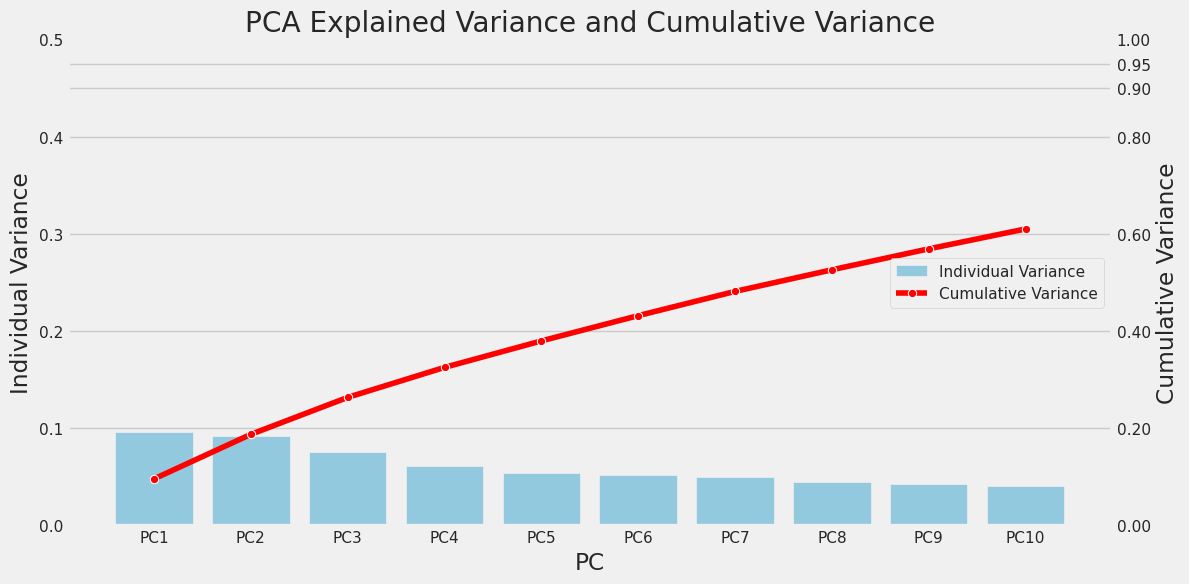

In [93]:
importlib.reload(graph)
graph.render_pca_component_plot(_explained_pc_team_attrs)

Our next step was look into the various team style/tactics/etc. attribute features they have used in their matches:

In [100]:
team_styles

['buildUpPlaySpeed',
 'buildUpPlaySpeedClass',
 'buildUpPlayDribbling',
 'buildUpPlayDribblingClass',
 'buildUpPlayPassing',
 'buildUpPlayPassingClass',
 'buildUpPlayPositioningClass',
 'chanceCreationPassing',
 'chanceCreationPassingClass',
 'chanceCreationCrossing',
 'chanceCreationCrossingClass',
 'chanceCreationShooting',
 'chanceCreationShootingClass',
 'chanceCreationPositioningClass',
 'defencePressure',
 'defencePressureClass',
 'defenceAggression',
 'defenceAggressionClass',
 'defenceTeamWidth',
 'defenceTeamWidthClass',
 'defenceDefenderLineClass']

We have previously attempted to include them into our model but their predictive power insignificant. PCA would allow us to reduce all these features into a limited number of components that can be possibly comapred between individual teams directly.  

However again this hasn't been very successful, 10 components (out of 21 features) only explain ~30% of all variance. This indicates that, this data:
  - has high Dimensionality
  - the relationship might non-linear or likely non existant

### Clustering

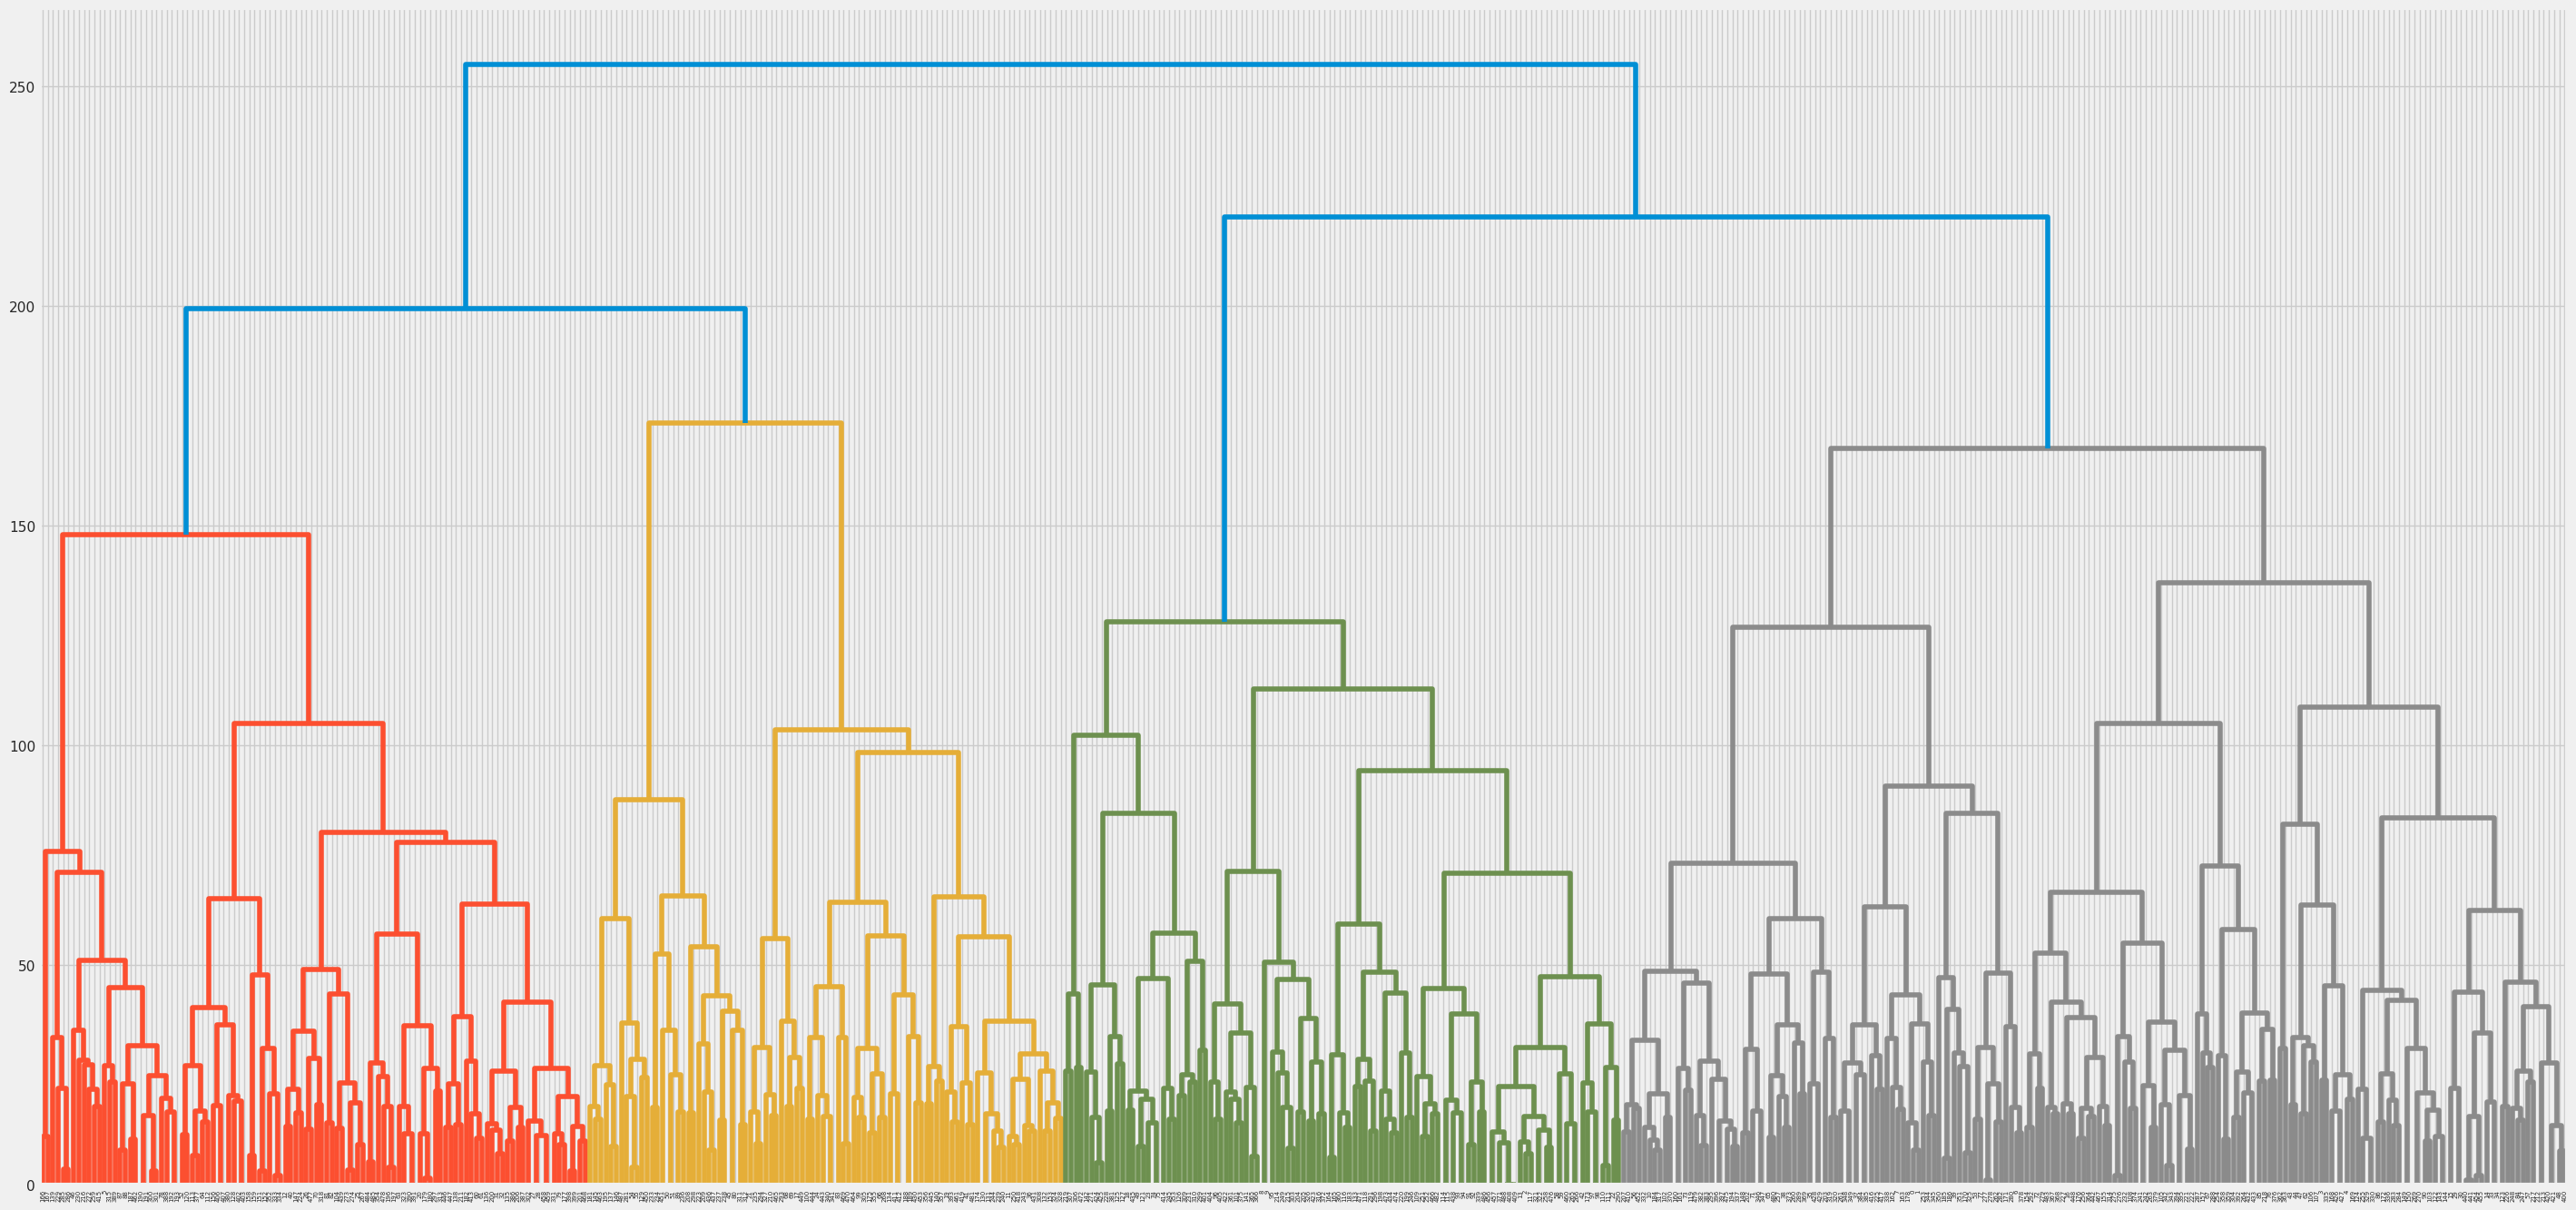

In [55]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 16))
dendrogram = sch.dendrogram(sch.linkage(team_attrs_df_encoded, method="ward"))

# Display dendrogram
plt.show()

Using hierarchical clustering with the same features doesn't seem to be that effectively either. We've attempted to determine whether some teams could be grouped together based on their style/tacticts/other attributes. However the result has proven to be disappointing even when multiple different hyperparameter combinations were tried:

In [56]:
from workbench.src import stats_utils

importlib.reload(stats_utils)
optimal_clusters = stats_utils.find_optimal_clusters(team_attrs_df_encoded)

/home/paulius/data/projects/football_m2_s4/workbench/src/stats_utils.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df["score_davies_bouldin"] = 1 / metrics_df["score_davies_bouldin"]


In [57]:
optimal_clusters

,name,component_method,n_components,method,cutoff,eps,min_samples,n_clusters,min_count_in_cluster,score_silhouette,score_calinski_harabasz,score_davies_bouldin,score
13,Hierarchical,None,None,ward,230,None,None,2,198,0.079399,44.468856,3.078634,0.800000
14,Hierarchical,None,None,ward,240,None,None,2,198,0.079399,44.468856,3.078634,0.800000
15,Hierarchical,None,None,ward,250,None,None,2,198,0.079399,44.468856,3.078634,0.800000
7,Hierarchical,None,None,ward,170,None,None,5,31,0.065273,37.352303,2.342327,0.506753
5,Hierarchical,None,None,ward,150,None,None,6,31,0.067596,36.096352,2.411916,0.506391
6,Hierarchical,None,None,ward,160,None,None,6,31,0.067596,36.096352,2.411916,0.506391
10,Hierarchical,None,None,ward,200,None,None,3,108,0.062023,41.589361,2.797015,0.476989
11,Hierarchical,None,None,ward,210,None,None,3,108,0.062023,41.589361,2.797015,0.476989
12,Hierarchical,None,None,ward,220,None,None,3,108,0.062023,41.589361,2.797015,0.476989
0,Hierarchical,None,None,ward,100,None,None,16,4,0.071681,26.141644,1.886573,0.470284


In [58]:
from scipy.cluster.hierarchy import linkage, fcluster

cluster_settings = {
    "": "38",
    "name": "Hierarchical",
    "component_method": "PCA",
    "n_components": "3.0",
    "method": "ward",
    "cutoff": "34.0",
    "eps": "NaN",
    "min_samples": "NaN",
    "n_clusters": "5",
    "min_count_in_cluster": "123",
    "score_silhouette": "0.253836",
    "score_calinski_harabasz": "479.193982",
    "score_davies_bouldin": "1.088382",
    "score": "0.738100",
}
# pca_df_3_comp = selected_pca_df = pca_df[["PC1", "PC2", "PC3"]]

Z = linkage(team_attrs_df_encoded, method=cluster_settings["method"])

clusters = fcluster(Z, cluster_settings["cutoff"], criterion="distance")

# df_reduced_tsne_cluster = df_reduced_tsne.copy()
# df_reduced_tsne_cluster["cluster"] = clusters

# pca_df_cluster = pca_df.copy()
# pca_df_cluster["cluster"] = clusters

source_df_cluster = team_attrs_df_encoded.copy()
source_df_cluster["cluster"] = clusters